In [1]:
import os,sys
import pyemma
import mdtraj as md
import matplotlib.pyplot as plt
from pyemma.util.contexts import settings
import numpy as np
from pyemma.coordinates import load
%matplotlib inline

In [2]:
pdb = md.load('aly_h2b1_fulldna_1.pdb')
files = ['aly_h2b1_fulldna.dcd']

In [9]:
# TICA


dim = 6
tica_lag = 5

tica = pyemma.coordinates.tica(data, dim=dim, lag=tica_lag, scaling = 'km')

tica_getoutput = tica.get_output()


tica_name_save = 'tica_getoutput'
if SAVE:
    np.save(tica_name_save, tica_getoutput)

print(f'tica complete')

tica complete


initialize kmeans++ centers:   0%|                      | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

(200, 6)


<Figure size 720x504 with 0 Axes>

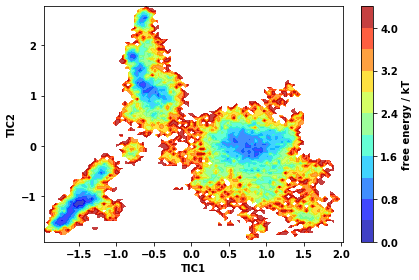

In [147]:
cluster = pyemma.coordinates.cluster_kmeans(tica_getoutput, k=200, max_iter=50, stride=2)

print(cluster.clustercenters.shape)

tica_in = np.load(f'tica_getoutput.npy', allow_pickle = True)
tica_cat = np.concatenate(tica_in).T

plt.figure(figsize=(10, 7))
IC_x, IC_y = 0, 1

pyemma.plots.plot_free_energy(tica_cat[IC_x], tica_cat[IC_y], cbar=True, cmap='jet', ncontours=10, alpha=0.75)
#plt.scatter(cluster.clustercenters[:, 0], cluster.clustercenters[:, 1], s=50, c='C1')
plt.xlabel('TIC1')
plt.ylabel('TIC2')
plt.tight_layout()
#plt.savefig('aly_015M_6us_FES_IC_h2b1.svg', format="svg",transparent=True, dpi = 600)

initialize kmeans++ centers:   0%|                      | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

(200, 6)


<Figure size 720x504 with 0 Axes>

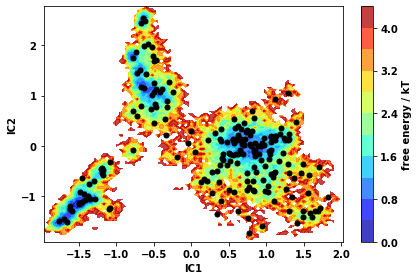

In [148]:
cluster = pyemma.coordinates.cluster_kmeans(tica_getoutput, k=200, max_iter=50, stride=2)

print(cluster.clustercenters.shape)

tica_in = np.load(f'tica_getoutput.npy', allow_pickle = True)
tica_cat = np.concatenate(tica_in).T

plt.figure(figsize=(10, 7))
IC_x, IC_y = 0, 1

pyemma.plots.plot_free_energy(tica_cat[IC_x], tica_cat[IC_y], cbar=True, cmap='jet', ncontours=10, alpha=0.75)
plt.scatter(cluster.clustercenters[:, 0], cluster.clustercenters[:, 1], s=25, c='k')
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.tight_layout()
#plt.savefig('aly_015M_6us_FES_IC_clusters_h2b1.svg', format="svg",transparent=True, dpi = 600)

In [13]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 5, 10, 20,50, 100], nits=5)

estimating MaximumLikelihoodMSM:   0%|                    | 0/7 [00:00<?, ?it/s]

Text(0, 0.5, 'implied timescale (ns)')

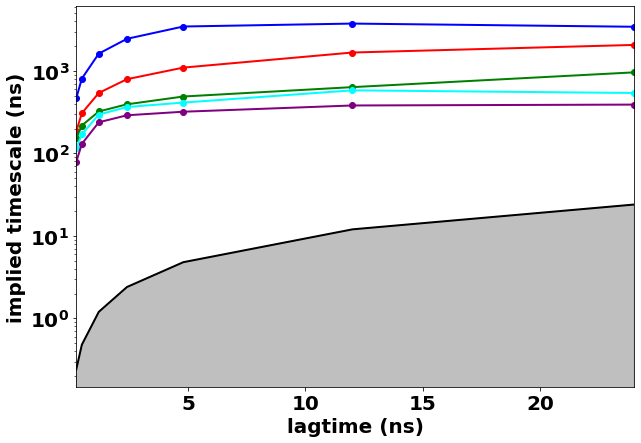

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))

frame_rate_ns = 0.24

pyemma.plots.plot_implied_timescales(its, units='ns', dt=frame_rate_ns, ax=ax, marker='o', markersize=6, linewidth=2)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlabel('lagtime (ns)', fontsize=20)
ax.set_ylabel('implied timescale (ns)', fontsize=20)

# Save the figure
#plt.savefig('aly_015M_implied_timescale_h2b1_6us.svg', format="svg", transparent=True, dpi=600)


In [16]:
#MSM 
msm_lag = 5

msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, msm_lag)

msm_save_name = 'msm'
if SAVE:
    msm.save(f'msm.h5',  overwrite=True)

print('------------------------------------------------------------------------')
print('MODEL COMPLETE')
print('------------------------------------------------------------------------')

22-05-24 15:26:46 pyemma._base.serialization.h5file INFO     overwriting model "default" in file msm.h5
------------------------------------------------------------------------
MODEL COMPLETE
------------------------------------------------------------------------


In [17]:
msm1 = pyemma.msm.bayesian_markov_model(cluster_dtrajs, lag=5, dt_traj='0.24 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[70]: compute stat. inefficiencies

pyemma.msm.estimators.bayesian_msm.BayesianMSM[70]: Sampling MSMs:   0%| | 0/100

fraction of states used = 1.00
fraction of counts used = 1.00


estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

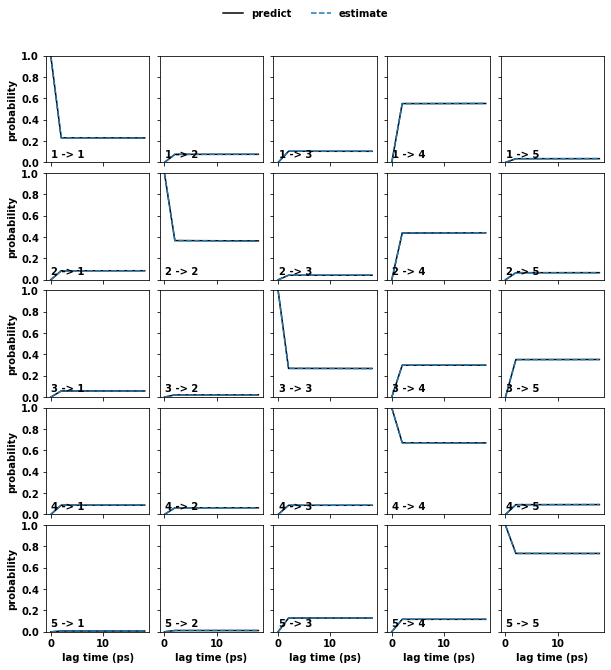

In [18]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=5, dt_traj='240 ps')
pyemma.plots.plot_cktest(msm.cktest(5), units='ns');
plt.savefig('aly_015M_ck_h2b1_6us.svg', format="svg", transparent=True, dpi=600)

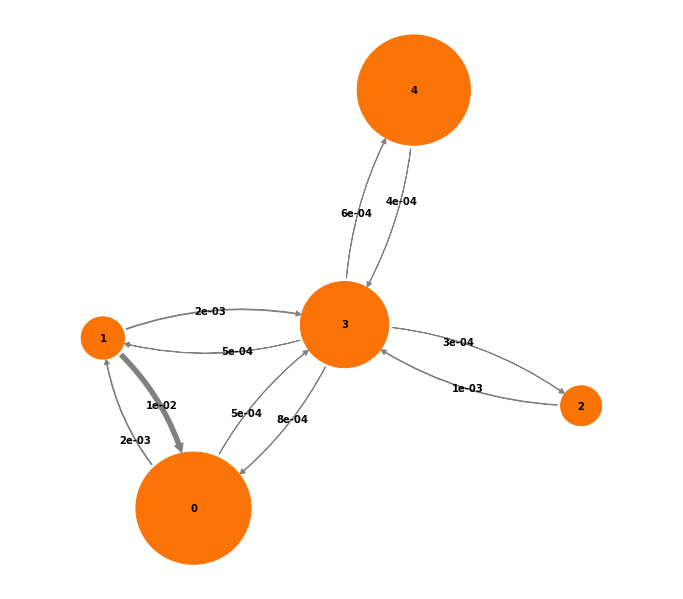

In [44]:
pyemma.plots.plot_markov_model(hmm, state_colors='#F97306')
plt.savefig('aly_015M_msm_transitionprob_h2b1_6us.svg', format="svg",transparent=True, dpi = 600)

In [42]:
nstates=5
msm.pcca(nstates)

PCCA(P=array([[0.87619, 0.     , ..., 0.     , 0.     ],
       [0.     , 0.74783, ..., 0.     , 0.     ],
       ...,
       [0.     , 0.     , ..., 0.77236, 0.     ],
       [0.     , 0.     , ..., 0.     , 0.5    ]]),
   m=5)

In [23]:
from itertools import product
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])
from pandas import DataFrame
mfpt = mfpt*100/1e6
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), 
columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4,5
1,0.00,589.14,477.97,9.77,160.64
2,774.47,0.00,479.22,16.46,161.37
3,843.95,659.90,0.00,17.89,129.21
4,763.71,591.13,433.34,0.00,127.45
5,914.91,730.41,516.13,100.81,0.00


In [25]:
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

In [26]:
tica_concatenated = np.concatenate(tica.get_output())

No handles with labels found to put in legend.


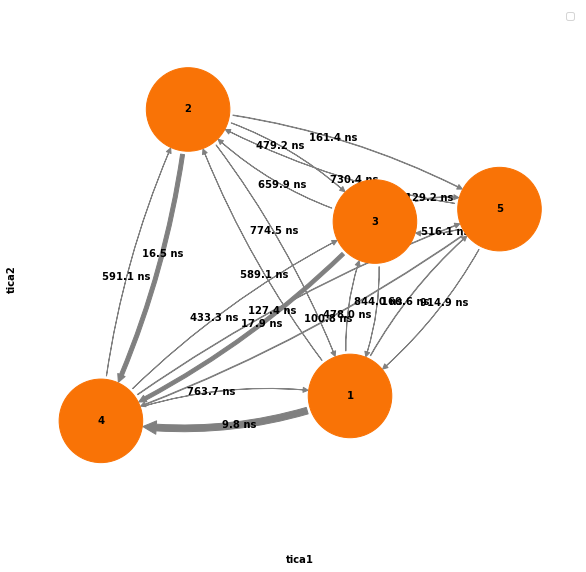

In [36]:
coarse_state_centers = np.array([[-0.7, -1.5], [-2, 0.8], [-0.5, -0.1], [-2.7, -1.7], [0.5, 0]])

size = np.array([0.0005, 0.0005, 0.0005, 0.0005, 0.0005])
colors = ('#F97306', '#F97306', '#F97306', '#F97306', '#F97306')  
state_labels = ['1', '2', '3', '4', '5']

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.set_xlabel('tica1')
ax.set_ylabel('tica2')
ax.set_xlim(tica_concatenated[:, 0].min(), tica_concatenated[:, 0].max())
ax.set_ylim(tica_concatenated[:, 1].min(), tica_concatenated[:, 1].max())

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers[:, :2],
    arrow_label_format='%.1f ns',
    arrow_labels=mfpt,
    arrow_scale=1.5,
    state_colors=colors,
    state_sizes=size,
    ax=ax,
    state_labels=state_labels,
    size=10, alpha=1
)
plt.savefig('aly_015M_tic_msm_h2b1_6us.svg', format="svg",transparent=True, dpi = 600)
plt.legend()
plt.show()

In [38]:
import pyemma
import numpy as np

stationary_dist = hmm.stationary_distribution
percentage_dist = stationary_dist * 100
for state, percentage in enumerate(percentage_dist):
    print(f"State {state}: {percentage:.2f}%")

State 0: 35.41%
State 1: 5.02%
State 2: 4.49%
State 3: 20.86%
State 4: 34.22%
